In [1]:
from lxml import etree

In [2]:
from typing import List, Tuple

In [3]:
def load_sentirueval_2016(file_name: str) -> Tuple[List[str], List[str]]:
    texts = []
    labels = []
    with open(file_name, mode='rb') as fp:
        xml_data = fp.read()
    root = etree.fromstring(xml_data)
    for database in root.getchildren():
        if database.tag == 'database':
            for table in database.getchildren():
                if table.tag != 'table':
                    continue
                new_text = None
                new_label = None
                for column in table.getchildren():
                    if column.get('name') == 'text':
                        new_text = str(column.text).strip()
                        if new_label is not None:
                            break
                    elif column.get('name') not in {'id', 'twitid', 'date'}:
                        if new_label is None:
                            label_candidate = str(column.text).strip()
                            if label_candidate in {'0', '1', '-1'}:
                                new_label = 'negative' if label_candidate == '-1' else \
                                    ('positive' if label_candidate == '1' else 'neutral')
                                if new_text is not None:
                                    break
                if (new_text is None) or (new_label is None):
                    raise ValueError('File `{0}` contains some error!'.format(file_name))
                texts.append(new_text)
                labels.append(new_label)
            break
    return texts, labels

In [4]:
texts, labels = load_sentirueval_2016('bank_train_2016.xml')

In [5]:
print('Number of texts is {0}, number of labels is {1}.'.format(len(texts), len(labels)))

Number of texts is 9392, number of labels is 9392.


In [6]:
from nltk.tokenize import TweetTokenizer
from rnnmorph.predictor import RNNMorphPredictor

predictor = RNNMorphPredictor(language='ru')
tokenizer = TweetTokenizer()

def drop_junk(s):
    return ' '.join([word for word in tokenizer.tokenize(s) if word.isalpha() or '!' in word or '?' in word \
                     or '(' in word or ')' in word])

def lemmatization(s):
    toks = tokenizer.tokenize(s)
    forms = predictor.predict(toks)
    return ' '.join([f.normal_form for f in forms])

texts, labels = load_sentirueval_2016('bank_train_2016.xml')

texts = list(map(drop_junk, texts))
texts = list(map(lemmatization, texts))

In [7]:
from stop_words import get_stop_words

stop_words = get_stop_words('ru')

In [8]:
import random

In [10]:
for idx in random.choices(list(range(len(texts))), k=20):
    print('{0} => {1}'.format(labels[idx], texts[idx]))

neutral => кредит наличный в томск сбербанк
neutral => опубликованный наконец новый список европейский санкция не оправдать пессимистичный ожидание указывать аналитик ук райффайзен капитал софа
neutral => газпромбанк и россельхозбанк обратиться за государственный поддержка в свет введённый санкция об это писать газета laquo ведомость raqu
neutral => алмаз можно снять любой сумма а сбер только определённый
neutral => сбербанк россия расчёт кредит
negative => новый система в бм двигаться по талон как бы в действие и как бы нет ! плюс консультант не мочь связать два слово !
neutral => взять кредит на свадьба в мурманск сбербанк
neutral => россельхозбанк провести в семинар для предприниматель
neutral => активация кредитный карта альфа банк
negative => анекдот из жизнь прийтись звонить в газпром банк и сообщать он что у ру поменяться реквизит а он не знать
neutral => правительство отказаться от идея разделить россельхозбанк ( рсхб ) на коммерческий банк и институт развитие профильный ведомс

In [11]:
positive_tweets = [texts[idx] for idx in range(len(texts)) if labels[idx] == 'positive']
negative_tweets = [texts[idx] for idx in range(len(texts)) if labels[idx] == 'negative']

In [12]:
for cur in positive_tweets[:5]: print(cur)

главный чтоб банк сбер и втб ! ! !
самый выгодный автокредит в втб
легко можно получить денежный кредит ы втб банка
снижение процентный ставка по кредит на недвижимость сбербанк
в наш сбербанк прийти американец и попросить сфоткаться с он у банкомат я ващий быть в шок и на фотка полюбома получиться смешной xd


In [13]:
for cur in negative_tweets[:5]: print(cur)

обязательно про сбербанк написать ! временами хлёсткий интернет магазин финт выкручивать )
втб и сбер точно операция или запрет на кредит ?
канада ввести санкция против газпромбанк вэба новатэк и российский оборонный компания
rt если сбер и втб попасть под санкция быть жопа
rt ввести санкция против оборонный и сырьевой компания и банк среди он в частность


In [14]:
from nltk import word_tokenize

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
from sklearn.feature_extraction.text import CountVectorizer  # TfIdfVectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [17]:
vectorizer = CountVectorizer(lowercase=True, tokenizer=word_tokenize)

In [18]:
vectorizer.fit(texts)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(tokenizer=<function word_tokenize at 0x00000246E4C57700>)

In [19]:
print(vectorizer.get_feature_names()[0:20])

['!', '(', ')', '-', '8', ':', ';', '=', '?', 'a', 'abncapital', 'admitad', 'ag', 'agro', 'airlines', 'ajhvf', 'alfa', 'alfabank', 'alfaclick', 'aliexpress']


In [20]:
print(len(vectorizer.get_feature_names()))

6660


In [21]:
X = vectorizer.transform(texts)

In [22]:
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


In [23]:
print(texts[0])

взять кредит тюмень альфа банк


In [24]:
print(X[0])

  (0, 419)	1
  (0, 555)	1
  (0, 852)	1
  (0, 2494)	1
  (0, 5979)	1


In [25]:
print(vectorizer.get_feature_names()[6321])

хакамада


In [26]:
print(vectorizer.get_feature_names()[5555])

спецпрограмма


In [27]:
print(vectorizer.get_feature_names()[6500])

шаттерсток


In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

In [29]:
transformer = TfidfTransformer().fit(X)

In [30]:
X_transformed = transformer.transform(X)

In [31]:
print(X_transformed[0])

  (0, 5979)	0.7391351947070658
  (0, 2494)	0.22539383399193713
  (0, 852)	0.4219051594577849
  (0, 555)	0.26376023593941833
  (0, 419)	0.3940854703028856


In [32]:
print(vectorizer.get_feature_names()[5555])

спецпрограмма


In [33]:
print(vectorizer.get_feature_names()[6500])

шаттерсток


In [34]:
tokens_with_IDF = list(zip(vectorizer.get_feature_names(), transformer.idf_))

In [35]:
for feature, idf in tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

4.417620 => !
4.805386 => (
4.443938 => )
8.355961 => -
9.049108 => 8
6.020586 => :
8.068278 => ;
8.201810 => =
4.440610 => ?
9.049108 => a
9.454573 => abncapital
9.454573 => admitad
9.049108 => ag
9.049108 => agro
9.454573 => airlines
9.454573 => ajhvf
9.049108 => alfa
8.355961 => alfabank
9.049108 => alfaclick
9.454573 => aliexpress


In [36]:
sorted_tokens_with_IDF = sorted(tokens_with_IDF, key=lambda it: (-it[1], it[0]))

In [37]:
for feature, idf in sorted_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => abncapital
9.454573 => admitad
9.454573 => airlines
9.454573 => ajhvf
9.454573 => aliexpress
9.454573 => api
9.454573 => app
9.454573 => apps
9.454573 => appstore
9.454573 => autopaymts
9.454573 => back
9.454573 => bankvtb
9.454573 => best
9.454573 => biznews
9.454573 => blackberry
9.454573 => blatt
9.454573 => bump
9.454573 => camp
9.454573 => cash
9.454573 => cetelem


In [38]:
from sklearn.feature_selection import SelectPercentile, chi2

In [39]:
selector = SelectPercentile(chi2, percentile=20)

In [40]:
selector.fit(X_transformed, labels)

SelectPercentile(percentile=20,
                 score_func=<function chi2 at 0x00000246F7D68A60>)

In [41]:
selected_tokens_with_IDF = [tokens_with_IDF[idx] for idx in selector.get_support(indices=True)]

In [42]:
print(len(selected_tokens_with_IDF))

1332


In [43]:
for feature, idf in selected_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

4.417620 => !
4.805386 => (
4.443938 => )
6.020586 => :
8.201810 => =
4.440610 => ?
9.049108 => apple
9.454573 => appstore
8.761426 => awards
8.538282 => boerse
9.049108 => brkng
9.049108 => cemitsvetic
9.454573 => come
9.454573 => euro
7.056678 => finance
7.439670 => fitch
8.761426 => ft
7.845135 => ftse
7.151988 => global
9.454573 => hsbc


In [44]:
selected_and_sorted_tokens_with_IDF = sorted(selected_tokens_with_IDF, key=lambda it: (-it[1], it[0]))

In [45]:
for feature, idf in selected_and_sorted_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => appstore
9.454573 => come
9.454573 => euro
9.454573 => hsbc
9.454573 => london
9.454573 => moneynews
9.454573 => n
9.454573 => nalexandrowa
9.454573 => play
9.454573 => plc
9.454573 => rdx
9.454573 => softkey
9.454573 => spo
9.454573 => автолюбитель
9.454573 => автоматический
9.454573 => автопроверка
9.454573 => адекватный
9.454573 => азс
9.454573 => ай
9.454573 => аккредитовый


In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
cls_Log = LogisticRegression(solver='liblinear', verbose=True)

In [48]:
X_transformed_and_selected = selector.transform(X_transformed)

In [49]:
cls_Log.fit(X_transformed_and_selected, labels)

[LibLinear]

LogisticRegression(solver='liblinear', verbose=True)

In [50]:
classes_list = list(cls_Log.classes_)

In [51]:
print(classes_list)

['negative', 'neutral', 'positive']


In [52]:
texts_for_testing, labels_for_testing = load_sentirueval_2016('banks_test_etalon.xml')

In [55]:
from sklearn.pipeline import Pipeline

In [56]:
pipeline_for_se_Log = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', cls_Log)
    ]
)

In [57]:
from sklearn.metrics import roc_curve
import numpy as np

In [58]:
probabilities = pipeline_for_se_Log.predict_proba(texts_for_testing)

In [59]:
y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

In [60]:
y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

In [61]:
y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
y_score_neutrals = probabilities[:, classes_list.index('neutral')]
fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

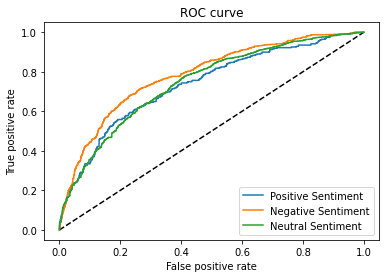

In [62]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [64]:
from sklearn.metrics import f1_score
predicted_labels = pipeline_for_se_Log.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.710836
F1-macro = 0.466278


In [65]:
from sklearn.metrics import classification_report
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.542188  0.452412  0.493248       767
     neutral   0.753497  0.890527  0.816301      2238
    positive   0.535714  0.048701  0.089286       308

    accuracy                       0.710836      3313
   macro avg   0.610466  0.463880  0.466278      3313
weighted avg   0.684330  0.710836  0.673922      3313



In [66]:
#sklearn.linear_model.SGDClassifier

In [67]:
from sklearn.linear_model import SGDClassifier

In [68]:
cls_SGDC = SGDClassifier(loss='log')

In [69]:
X_transformed_and_selected = selector.transform(X_transformed)

In [70]:
cls_SGDC.fit(X_transformed_and_selected, labels)

SGDClassifier(loss='log')

In [71]:
classes_list = list(cls_SGDC.classes_)

In [118]:
print(classes_list)

['negative', 'neutral', 'positive']


In [119]:
texts_for_testing, labels_for_testing = load_sentirueval_2016('banks_test_etalon.xml')

In [120]:
from sklearn.pipeline import Pipeline

In [72]:
pipeline_for_se_SGDC = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', cls_SGDC)
    ]
)

In [73]:
from sklearn.metrics import roc_curve
import numpy as np

In [74]:
probabilities = pipeline_for_se_SGDC.predict_proba(texts_for_testing)

In [75]:
y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

In [104]:
y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

In [105]:
y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
y_score_neutrals = probabilities[:, classes_list.index('neutral')]
fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

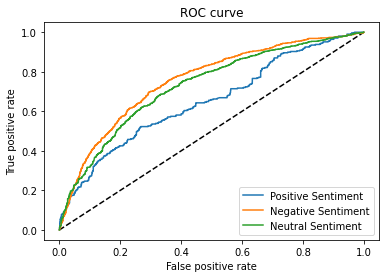

In [106]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [107]:
from sklearn.metrics import f1_score
predicted_labels =pipeline_for_se_SGDC.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.713251
F1-macro = 0.472583


In [108]:
from sklearn.metrics import classification_report
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.546440  0.460235  0.499646       767
     neutral   0.756070  0.890527  0.817809      2238
    positive   0.548387  0.055195  0.100295       308

    accuracy                       0.713251      3313
   macro avg   0.616966  0.468652  0.472583      3313
weighted avg   0.688230  0.713251  0.677445      3313



In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
f1_macro_scorer = make_scorer(f1_score, average='macro')
cv_GridSearchCV = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={'C': [1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3], 'penalty': ['l1', 'l2']},
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [110]:
cv_GridSearchCV.fit(X_transformed_and_selected, labels)

GridSearchCV(estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10.0, 100.0, 1000.0],
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(f1_score, average=macro))

In [111]:
print(cv_GridSearchCV.best_params_)

{'C': 10.0, 'penalty': 'l1'}


In [112]:
best_cls = LogisticRegression(solver='liblinear', verbose=True, C=10.0, penalty='l1')
best_cls.fit(X_transformed_and_selected, labels)

[LibLinear]

LogisticRegression(C=10.0, penalty='l1', solver='liblinear', verbose=True)

In [113]:
best_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', best_cls)
    ]
)

In [114]:
probabilities = best_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
y_score_neutrals = probabilities[:, classes_list.index('neutral')]
fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

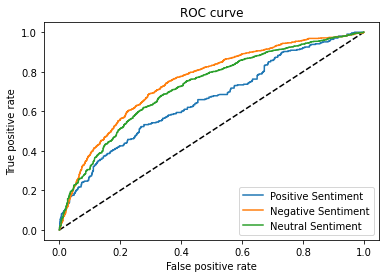

In [115]:
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [116]:
predicted_labels = best_pipeline_for_se.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.676426
F1-macro = 0.476153


In [117]:
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.474839  0.479791  0.477302       767
     neutral   0.757102  0.821716  0.788087      2238
    positive   0.311927  0.110390  0.163070       308

    accuracy                       0.676426      3313
   macro avg   0.514622  0.470632  0.476153      3313
weighted avg   0.650368  0.676426  0.658030      3313



In [143]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
f1_macro_scorer = make_scorer(f1_score, average='macro')

cv_RandomizedSearchCV = RandomizedSearchCV(  
    estimator=LogisticRegression(solver='saga'),
    param_distributions={'C': [1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3], 'penalty': ['l1', 'l2']},
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [144]:
cv_RandomizedSearchCV.fit(X_transformed_and_selected, labels)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


RandomizedSearchCV(estimator=LogisticRegression(solver='saga'), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10.0, 100.0,
                                              1000.0],
                                        'penalty': ['l1', 'l2']},
                   scoring=make_scorer(f1_score, average=macro))

In [145]:
print(cv_RandomizedSearchCV.best_params_)

{'penalty': 'l2', 'C': 100.0}


In [146]:
#logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0)
#best_cls_Random = LogisticRegression(solver='liblinear', verbose=True, C=10.0, penalty='l1')
best_cls_Random = LogisticRegression(solver='saga', verbose=True, C=10.0, penalty='l1', max_iter=200, random_state=0)
best_cls_Random.fit(X_transformed_and_selected, labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 11 seconds


C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s finished


LogisticRegression(C=10.0, max_iter=200, penalty='l1', random_state=0,
                   solver='saga', verbose=True)

In [148]:
best_pipeline_for_se_Random = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', best_cls_Random)
    ]
)

In [149]:
probabilities = best_pipeline_for_se_Random.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
y_score_neutrals = probabilities[:, classes_list.index('neutral')]
fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

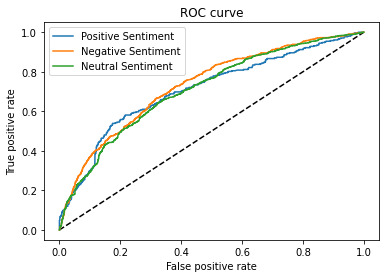

In [150]:
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [151]:
predicted_labels = best_pipeline_for_se_Random.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.649562
F1-macro = 0.464651


In [139]:
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.522696  0.495437  0.508701       767
     neutral   0.762372  0.867292  0.811455      2238
    positive   0.550000  0.071429  0.126437       308

    accuracy                       0.707214      3313
   macro avg   0.611689  0.478053  0.482198      3313
weighted avg   0.687141  0.707214  0.677680      3313

